## X-SAPR CMAC 2.0

Test for second trip rejection and using texture filter and gate ids to
analysis.

In [1]:
import cartopy
import imp
import matplotlib
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import operator
import os
import pandas as pd
import pyart
import tempfile
import yt

from boto.s3.connection import S3Connection
from datetime import datetime

import processing_code

%matplotlib inline
get_ipython().magic(
    'install_ext https://raw.github.com/cpcloud/ipython-\
autotime/master/autotime.py')
get_ipython().magic('load_ext autotime')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR:root:Line magic function `%install_ext` not found.


Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


In [2]:
# Helper function for the search.
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.

    Parameters
    ----------
    site : string
        four letter radar designation.
    datetime_t : datetime
        desired date time.

    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime.

    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket.
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files.
    bucket_list = list(bucket.list(prefix = my_pref))

    # We are going to create a list of keys and datetimes to allow easy searching.
    keys = []
    datetimes = []

    # Populate the list.
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    #find the closest available radar to your datetime

    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

time: 81.6 ms


In [3]:
radar = pyart.io.read('/home/zsherman/xsapr_sgp/data/05_19_2017/XSW170519014005.RAW54Y8')
radar.altitude['data'][0] = 320.0

time: 980 ms


In [4]:
radar.altitude

{'data': array([ 320.]),
 'long_name': 'Altitude',
 'positive': 'up',
 'standard_name': 'Altitude',
 'units': 'meters'}

time: 4.1 ms


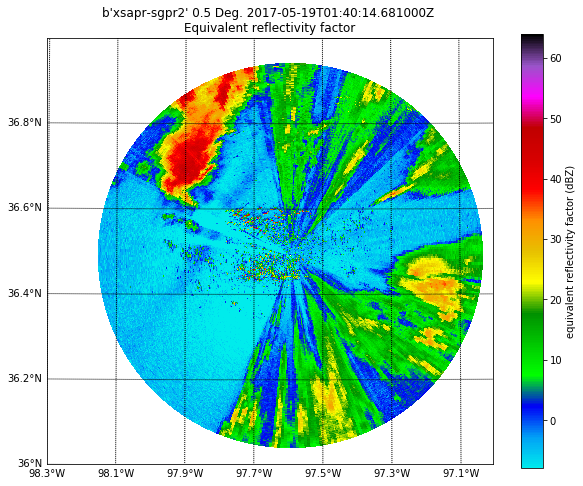

time: 998 ms


In [5]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('reflectivity', sweep=0, resolution='c',
                     vmin=-8, vmax=64, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

In [6]:
time_at_start_of_radar = netCDF4.num2date(radar.time['data'][0], 
                                          radar.time['units'])
my_radar = get_radar_from_aws('KVNX', time_at_start_of_radar )

ERROR:boto:Caught exception reading instance data
Traceback (most recent call last):
  File "/home/zsherman/anaconda3/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 1107, in request
    self._send_request(method, url, body, headers)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 1152, in _send_request
    self.endheaders(body)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 1103, in endheaders
    self._send_output(message_body)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/home/zsherman/anaconda3/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/home/zsherman/a

time: 10.8 s


In [7]:
my_radar.fields.keys()

dict_keys(['cross_correlation_ratio', 'velocity', 'differential_phase', 'reflectivity', 'differential_reflectivity', 'spectrum_width'])

time: 1.96 ms


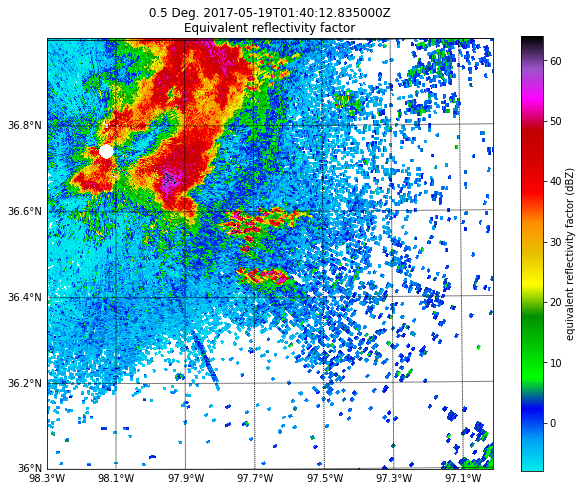

time: 1.62 s


In [8]:
display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('reflectivity', sweep=0, resolution='c',
                     vmin=-8, vmax=64, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

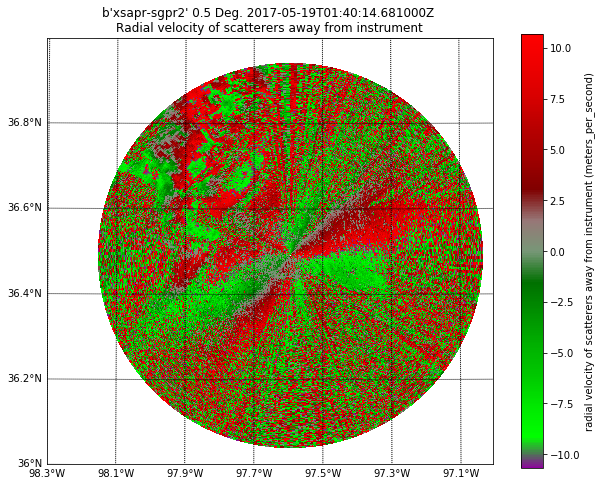

time: 1.1 s


In [9]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('velocity', sweep=0, resolution='c',
                    vmin=-nyq, vmax=nyq, mask_outside=False,
                    cmap=pyart.graph.cm.NWSVel,
                    min_lat=min_lat, min_lon=min_lon,
                    max_lat=max_lat, max_lon=max_lon,
                    lat_lines=lal, lon_lines=lol)
# plt.savefig('')

In [10]:
print(radar.fixed_angle['data'])

[  0.49987793   1.49963379   2.49938965   3.49914551   4.49890137
   5.49865723   6.49841309   7.49816895   8.4979248    9.49768066
  10.49743652  11.50268555  12.50244141  14.0020752   15.00183105
  17.00134277  20.00061035  24.99938965  29.99816895  40.0012207
  49.9987793   54.99755859  60.00183105]
time: 4.65 ms


In [11]:
radar_start_date = netCDF4.num2date(
    radar.time['data'][0], radar.time['units'])
print(radar_start_date)
ymd_string = datetime.strftime(radar_start_date, '%Y%m%d')
hms_string = datetime.strftime(radar_start_date, '%H%M%S')
print(ymd_string, hms_string)

2017-05-19 01:40:14.681000
20170519 014014
time: 16.6 ms


In [12]:
sndfile = '/home/zsherman/xsapr_sgp/data/sonde_05_2017/sgpsondewnpnC1.b1.20170517.052500.cdf'
# soundings_dir = '/home/zsherman/xsapr_sgp/data/sonde_05_2017/'
# z_dict, temp_dict, snr = processing_code.snr_and_sounding(
    # radar, soundings_dir, override_file=sndfile)
sonde = netCDF4.Dataset(sndfile)
print(sonde.variables.keys())

odict_keys(['base_time', 'time_offset', 'time', 'qc_time', 'pres', 'qc_pres', 'tdry', 'qc_tdry', 'dp', 'qc_dp', 'wspd', 'qc_wspd', 'deg', 'qc_deg', 'rh', 'qc_rh', 'u_wind', 'qc_u_wind', 'v_wind', 'qc_v_wind', 'wstat', 'asc', 'qc_asc', 'lat', 'lon', 'alt'])
time: 9.39 ms


In [13]:
radar.instrument_parameters['nyquist_velocity']['data']

array([ 10.69499969,  10.69499969,  10.69499969, ...,  10.69499969,
        10.69499969,  10.69499969], dtype=float32)

time: 3.92 ms


In [14]:
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(
    sonde.variables['tdry'][:], sonde.variables['alt'][:], radar)
texture = processing_code.get_texture(radar)

time: 4.3 s


In [15]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)

time: 2.16 s


In [16]:
radar.add_field('sounding_temperature', temp_dict, replace_existing=True)
radar.add_field('height', z_dict, replace_existing=True)
radar.add_field('SNR', snr, replace_existing=True)
radar.add_field('velocity_texture', texture, replace_existing=True)
print(radar.fields.keys())

dict_keys(['cross_correlation_ratio', 'specific_differential_phase', 'differential_phase', 'velocity_texture', 'differential_reflectivity', 'total_power', 'sounding_temperature', 'normalized_coherent_power', 'velocity', 'SNR', 'reflectivity', 'height', 'spectrum_width'])
time: 4.9 ms


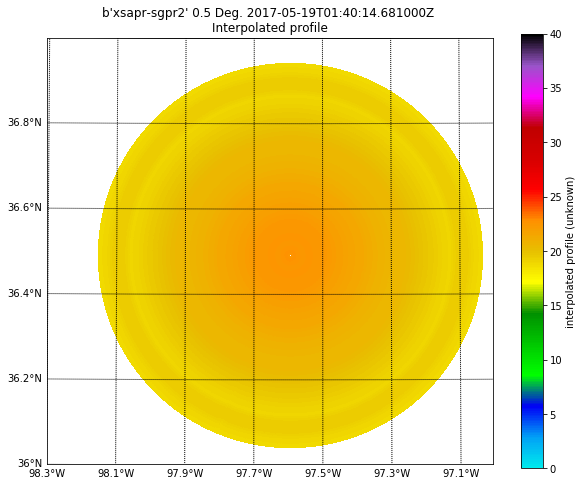

time: 887 ms


In [17]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('sounding_temperature', sweep=0, resolution='c',
                     vmin=-0, vmax=40, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

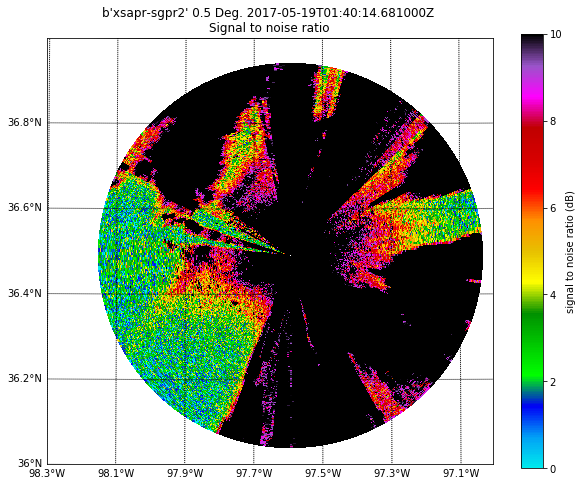

time: 826 ms


In [18]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('SNR', sweep=0, resolution='c',
                     vmin=0, vmax=10, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

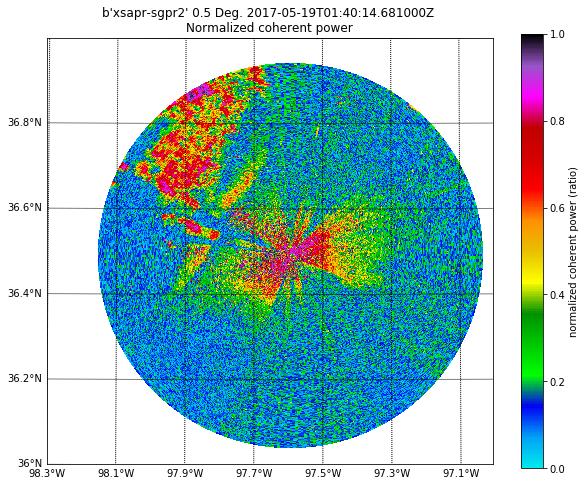

time: 933 ms


In [19]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('normalized_coherent_power', sweep=0,
                     resolution='c', vmin=0, vmax=1,
                     mask_outside=False, cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

In [20]:
my_fuzz, cats = processing_code.do_my_fuzz(radar)
print(my_fuzz['notes'])
radar.add_field('gate_id', my_fuzz, 
                replace_existing=True)

print(radar.fields['gate_id']['notes'])
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print(pair_str)
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})

sorted_cats = sorted(cat_dict.items(), key=operator.itemgetter(1))

##
## CMAC calculation using fuzzy logic:
##    Doing rain
##    Doing no_scatter
##    Doing multi_trip
##    Doing melting
##    Doing snow
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 9199, 9199, 9199]), array([ 0,  1,  2, ..., 26, 27, 28]))
##    Doing hard constraining multi_trip
##     (array([4400, 4400, 4400, ..., 9199, 9199, 9199]), array([480, 481, 482, ..., 498, 499, 500]))
##    Doing hard constraining melting
##     (array([1600, 1600, 1600, ..., 9199, 9199, 9199]), array([476, 477, 478, ..., 498, 499, 500]))
##    Doing hard constraining rain
##     (array([2000, 2000, 2000, ..., 9199, 9199, 9199]), array([426, 427, 428, ..., 321, 322, 323]))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 9199, 9199, 9199]), array([  0,   1,   2, ..., 498, 499, 500]))
2
0:melting,1:rain,2:snow,3:multi_trip,4:no_scatter
0:melting,1:rain,2:snow,3:multi_trip,4:no_scatter
0:melting
1:rain
2:snow
3:multi_trip
4:no_scatter
time: 36 s


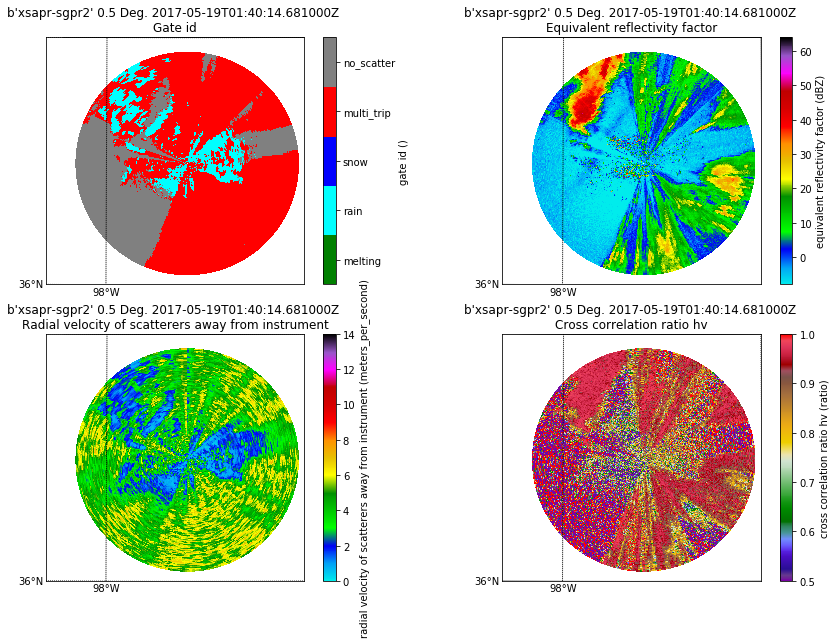

time: 4.5 s


In [21]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lat_lines = np.arange(min_lon, max_lon, .2)

sw = 0

display = pyart.graph.RadarMapDisplay(radar)

f = plt.figure(figsize=[15, 10])
plt.subplot(2, 2, 1) 
lab_colors=['green', 'cyan', 'blue', 'red', 'grey']
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep=sw, min_lon=min_lon,
                     max_lon=max_lon, min_lat=min_lat,
                     max_lat=max_lat, resolution='l', cmap=cmap,
                     vmin=0, vmax=5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs = np.linspace(0, len(cats) - 1, len(cats)) + 0.5
display.cbs[-1].locator = matplotlib.ticker.FixedLocator(tick_locs)
catty_list = [sorted_cats[i][0] for i in range(len(sorted_cats))]
display.cbs[-1].formatter = matplotlib.ticker.FixedFormatter(catty_list)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep=sw, vmin=-8, vmax=64,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='l', cmap=pyart.graph.cm.NWSRef)

plt.subplot(2, 2, 3) 
display.plot_ppi_map('velocity_texture', sweep=sw, vmin=0, vmax=14, 
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='l', cmap=pyart.graph.cm.NWSRef)
plt.subplot(2, 2, 4) 
display.plot_ppi_map('cross_correlation_ratio', sweep=sw, vmin=.5,
                     vmax=1, min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat, resolution='l',
                     cmap=pyart.graph.cm.Carbone42)

# plt.savefig('')

In [22]:
print(radar.fields['gate_id']['notes'])
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print(pair_str)
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})

0:melting,1:rain,2:snow,3:multi_trip,4:no_scatter
0:melting
1:rain
2:snow
3:multi_trip
4:no_scatter
time: 7.46 ms


In [23]:
print(cat_dict)

{'rain': 1, 'no_scatter': 4, 'melting': 0, 'multi_trip': 3, 'snow': 2}
time: 2.21 ms


In [24]:
happy_gates = pyart.correct.GateFilter(radar)
happy_gates.exclude_all()
happy_gates.include_equal('gate_id', cat_dict['rain'])
happy_gates.include_equal('gate_id', cat_dict['melting'])
happy_gates.include_equal('gate_id', cat_dict['snow'])

time: 17.1 ms


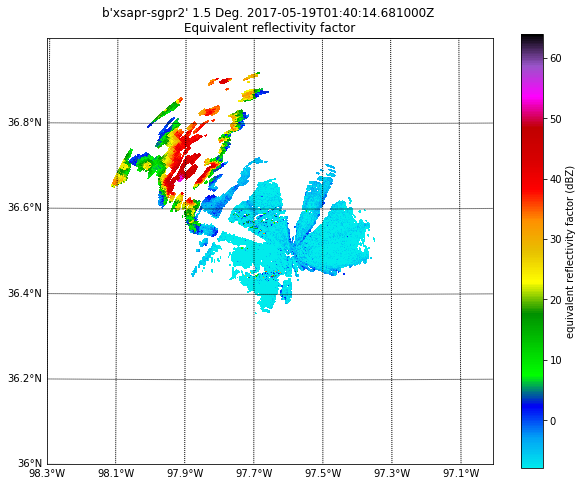

time: 810 ms


In [25]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('reflectivity', sweep=1, resolution='c',
                     vmin=-8, vmax=64, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol,
                     gatefilter=happy_gates)
# plt.savefig('')

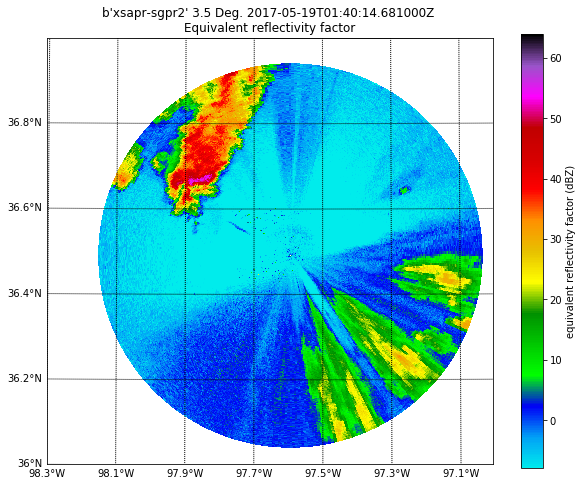

time: 1.14 s


In [26]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97
lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=[10, 8])
display.plot_ppi_map('reflectivity', sweep=3, resolution='c',
                     vmin=-8, vmax=64, mask_outside=False,
                     cmap=pyart.graph.cm.NWSRef,
                     min_lat=min_lat, min_lon=min_lon,
                     max_lat=max_lat, max_lon=max_lon,
                     lat_lines=lal, lon_lines=lol)
# plt.savefig('')

In [27]:
grids = pyart.map.grid_from_radars(
    (radar, ), grid_shape=(46, 251, 251),
    grid_limits=((0, 15000.0), (-50000, 50000), (-50000, 50000)),
    fields=list(radar.fields.keys()), gridding_algo="map_gates_to_grid",
    weighting_function='BARNES', gatefilters=(happy_gates, ),
    min_radius=200.0)

time: 35.2 s


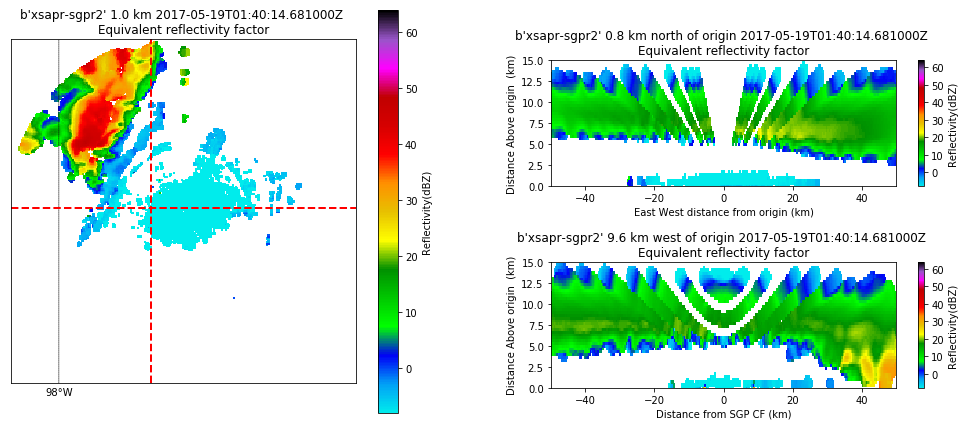

time: 1.82 s


In [28]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# Panel sizes.
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# Parameters.
level = 3
vmin = -8
vmax = 64
lat = 36.5
lon = -97.7

# Panel 1, basemap, radar reflectivity and NARR overlay.
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 2))
display.plot_grid('reflectivity', level=level, vmin=vmin, vmax=vmax,
                  cmap=pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# Panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                             cmap=pyart.graph.cm.NWSRef)
ax2.set_ylim([0, 15])
ax2.set_xlim([-50, 50])
ax2.set_xlabel('Distance from SGP CF (km)')

# Panel 3, latitude slice.
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0, 15])
ax3.set_xlim([-50, 50])
display.plot_latitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap=pyart.graph.cm.NWSRef)
# plt.savefig('')

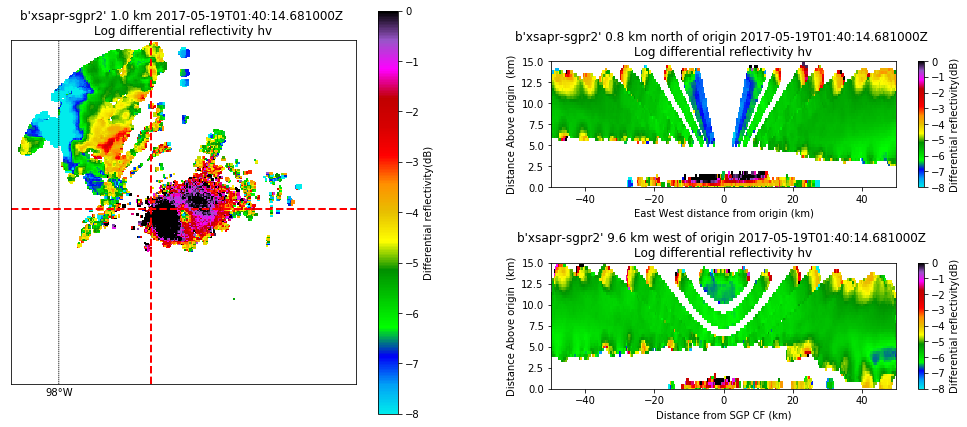

time: 1.28 s


In [29]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# Panel sizes.
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# Parameters.
level = 3
vmin = -8
vmax = 0
lat = 36.5
lon = -97.7

# Panel 1, basemap, radar reflectivity and NARR overlay.
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 2))
display.plot_grid('differential_reflectivity', level=level, vmin=vmin, vmax=vmax,
                  cmap=pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# Panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin,
                             vmax=vmax, cmap=pyart.graph.cm.NWSRef)
ax2.set_ylim([0, 15])
ax2.set_xlim([-50, 50])
ax2.set_xlabel('Distance from SGP CF (km)')

# Panel 3, latitude slice.
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0, 15])
ax3.set_xlim([-50, 50])
display.plot_latitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin,
                            vmax=vmax, cmap=pyart.graph.cm.NWSRef)
# plt.savefig('')

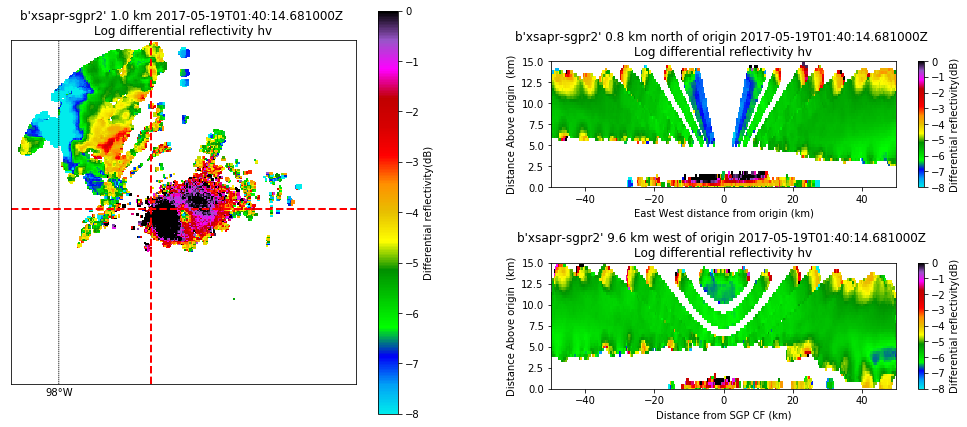

time: 1.01 s


In [30]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# Panel sizes.
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# Parameters.
level = 3
vmin = -8
vmax = 0
lat = 36.5
lon = -97.7

# Panel 1, basemap, radar reflectivity and NARR overlay.
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 2))
display.plot_grid('differential_reflectivity', level=level, vmin=vmin, vmax=vmax,
                  cmap=pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# Panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                             cmap=pyart.graph.cm.NWSRef)
ax2.set_ylim([0, 15])
ax2.set_xlim([-50, 50])
ax2.set_xlabel('Distance from SGP CF (km)')

# Panel 3, latitude slice.
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0, 15])
ax3.set_xlim([-50, 50])
display.plot_latitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap=pyart.graph.cm.NWSRef)

yt : [INFO     ] 2017-08-24 13:30:01,922 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-08-24 13:30:01,922 Parameters: domain_dimensions         = [251 251  46]
yt : [INFO     ] 2017-08-24 13:30:01,924 Parameters: domain_left_edge          = [-50000. -50000.      0.]
yt : [INFO     ] 2017-08-24 13:30:01,925 Parameters: domain_right_edge         = [ 50000.  50000.  15000.]
yt : [INFO     ] 2017-08-24 13:30:01,926 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-08-24 13:30:02,118 xlim = -50000.000000 50000.000000
yt : [INFO     ] 2017-08-24 13:30:02,119 ylim = -50000.000000 50000.000000
yt : [INFO     ] 2017-08-24 13:30:02,120 xlim = -50000.000000 50000.000000
yt : [INFO     ] 2017-08-24 13:30:02,121 ylim = -50000.000000 50000.000000
yt : [INFO     ] 2017-08-24 13:30:02,122 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [WARNING  ] 2017-08-24 13:30:02,166 Plot image for field ('gas', 'density') has both positive and negative 


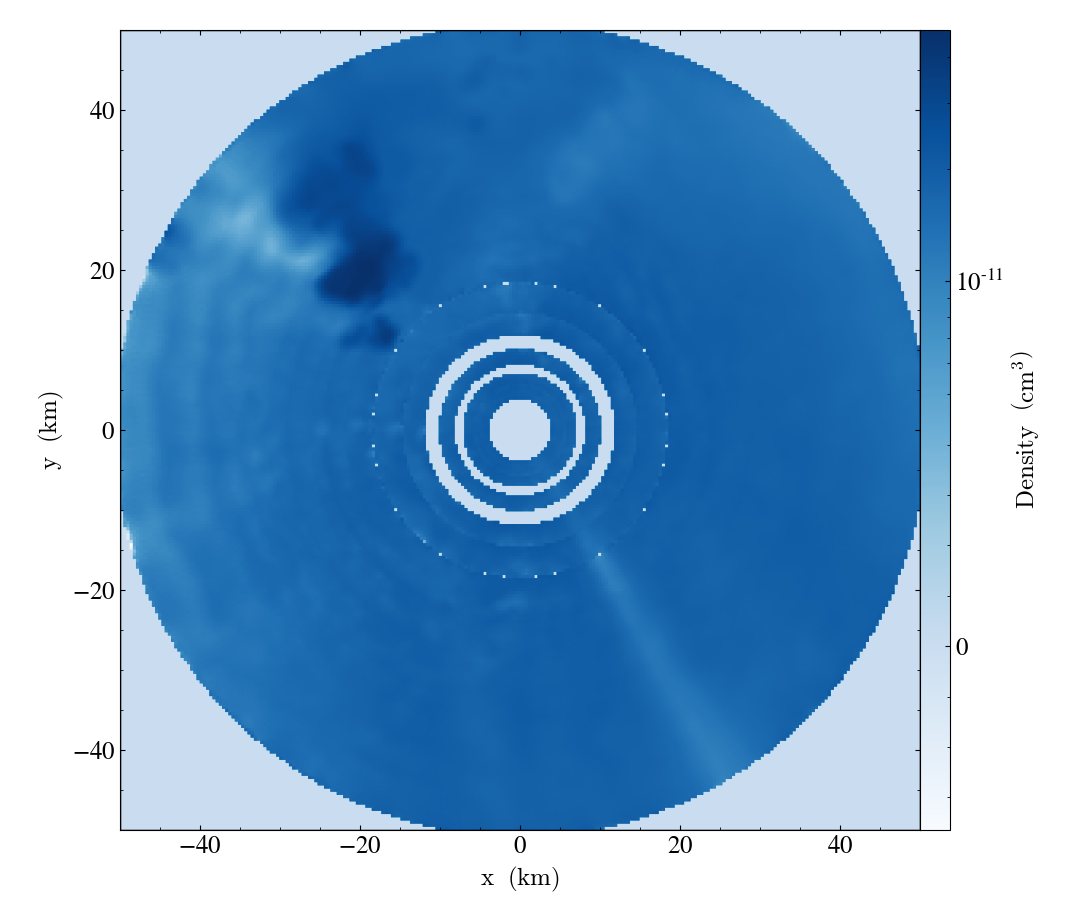

time: 1.33 s


In [31]:
arr = grids.fields['reflectivity']['data']
ff = arr.transpose()
data = dict(density = (ff, "((mm**6)/(m**3))"))
bbox = np.array([[-50000., 50000.], [-50000., 50000.],[0., 15000.0]])
ds = yt.load_uniform_grid(data, ff.shape, length_unit="m", bbox=bbox)

slc = yt.SlicePlot(ds, "z", ["density"])
slc.set_cmap("density", "Blues")
slc.annotate_grids(cmap=None)
slc.show()

yt : [INFO     ] 2017-08-24 13:30:03,241 Setting default field to ('gas', 'density')
yt : [INFO     ] 2017-08-24 13:30:03,270 Creating transfer function
yt : [INFO     ] 2017-08-24 13:30:03,271 Calculating data bounds. This may take a while.  Set the TranferFunctionHelper.bounds to avoid this.
yt : [INFO     ] 2017-08-24 13:30:03,416 Rendering scene (Can take a while).
yt : [INFO     ] 2017-08-24 13:30:03,428 Creating volume


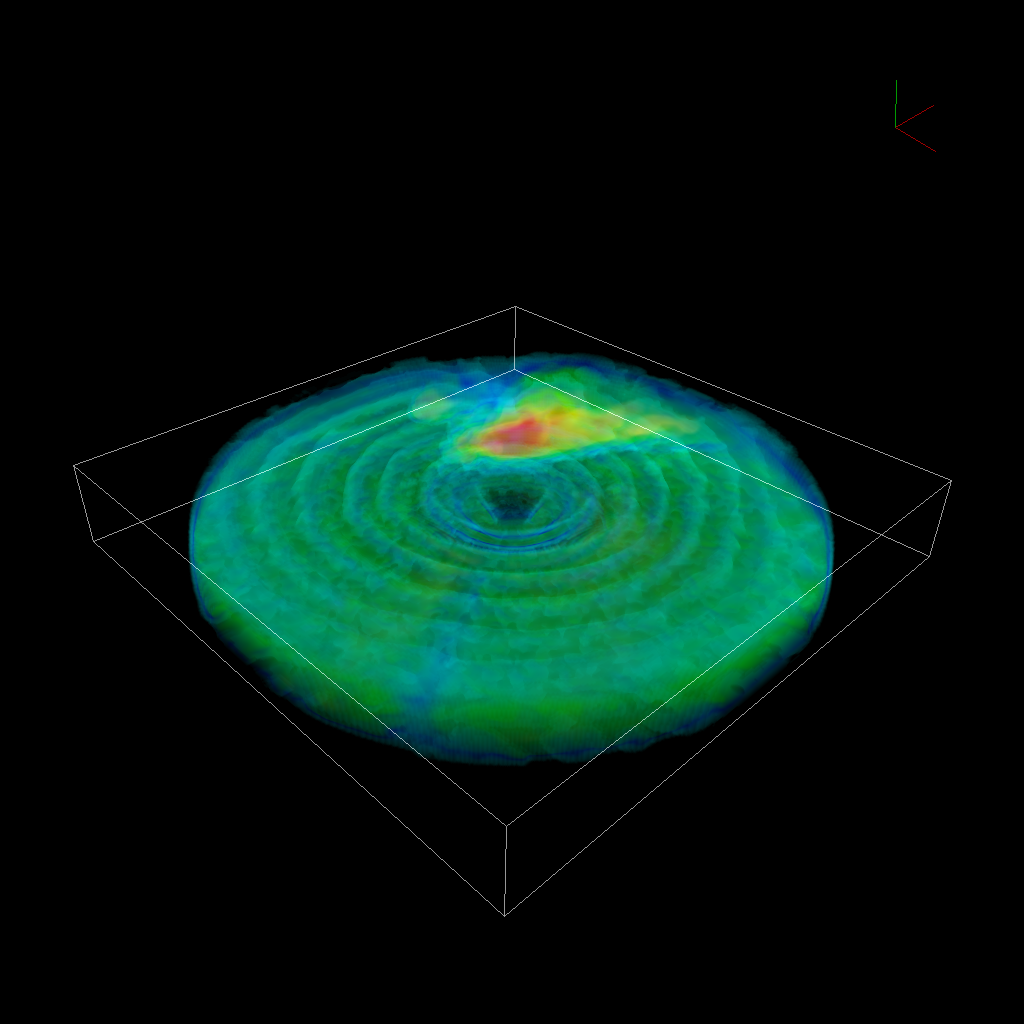

time: 3.83 s


In [32]:
sc = yt.create_scene(ds, lens_type='perspective')

source = sc[0]

source.set_field('density')
source.set_log(False)

# Modify the transfer function
sc.camera.focus = ds.domain_center
sc.camera.resolution = 1024

sc.camera.roll(np.pi)
# Move the camera position to the other side of the dataset.
sc.camera.position = ds.arr([1, -1, 1], 'unitary')

# First get the render source, in this case the entire domain, with field ('gas','density').
render_source = sc.get_source(0)

# Clear the transfer function.
render_source.transfer_function.clear()
# Map a range of density values (in log space) to the Reds_r colormap.
render_source.transfer_function.map_to_colormap(
    ds.quan(-10.0, 'g/cm**3'),
    ds.quan(64., 'g/cm**3'),
    scale=15.0, colormap=pyart.graph.cm.NWSRef)

# Draw the domain boundary.
sc.annotate_axes(alpha=.52)

sc.annotate_domain(ds, color=[1, 1, 1, 0.51])

# sc.save('')
sc.show()